# Poster Notebook: Kruskal Wallis test for associations between Protein/Gene Expression and Clinical Features
```
Created: 09-20-2020
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/FeaturedNotebooks/ACM_BCB_2020_POSTER_KruskalWallisTest_ProteinGeneExpression_vs_ClinicalFeatures.ipynb
Note: This notebook supports the POSTER : "Multi-omics Data Integration in the Cloud: Analysis 
of Statistically Significant Associations Between Clinical and Molecular Features in Breast Cancer" 
by K. Abdilleh, B. Aguilar, and R. Thomson , presented in the ACM Conference on Bioinformatics, 
Computational Biology, and Health Informatics, 2020.
```
***

This Notebook computes statistically significant associations between Protein/Gene expression and clinical features of Breast cancer, using data available in TCGA BigQuery tables.

The associations were computed using the Kruskal Wallis (KW) test, implemented as user defined function in Bigquery. Details of the KW test and its implementatin can be found in: https://github.com/jrossthomson/bigquery-utils/tree/master/udfs/statslib

Violin plots are presented for the clinical features with the most significant associations with protein and gene expression.

# Setup

In [7]:
import sys
#! {sys.executable} -m pip install matplotlib seaborn
#! {sys.executable} -m pip install google-cloud
#! {sys.executable} -m pip install google-cloud
#! {sys.executable} -m pip install google-auth
print({sys.executable})
from platform import python_version

print(python_version())

{'/usr/bin/python3'}
3.6.9


# Authentication


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_gbq
from google.colab import auth
import google.auth

auth.authenticate_user()
# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.

credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)



# Run Kruskal Wallis test over Proteins Expression, Gene expression, and Clinical data 
The code below uses the following three tables available in ISB-CGC :
- Protein expression table: `isb-cgc.TCGA_hg19_data_v0.Protein_Expression`
- Gene Expression table: `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM`
- Clinical data: `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT`

The Kruskal Wallis test is implemented in a user defined function called  `isb-cgc-bq.functions.kruskal_wallis_current`.

The code below uses KW to compute significant (p-value < 0.001) associations between Protein expression and Clinical Features in Breat cancer patients.  The output (protein names) are then used in a second KW test that identify significant associations between clinical features and both gene and protein expression.

The final output is a table with protein/genes, clinical features, and p-values of the Kruskal Wallis tests.


In [9]:
cancer_type = 'TCGA-BRCA' # https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations
significance_level = '0.001'
project_id="" # write your project id here
sql = '''
with the_proteins as (
  SELECT p.project_short_name as study, gene_name as g, c.feature.key as c, `isb-cgc-bq.functions.kruskal_wallis_current`(array_agg((c.feature.value,protein_expression))) as reso
  FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` p
  JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
  ON c.case_barcode = substr(p.sample_barcode,0,12)
  WHERE 1=1 AND c.feature.value != "null" AND p.project_short_name = "{0}"
  GROUP BY study, g, c
  HAVING reso.DoF > 1 and reso.DoF < 10 #and reso.p <= {1}
  ORDER BY study, reso.p, c
) # the_goods
,
the_goods as (
  SELECT HGNC_gene_symbol as g, c.feature.key as c, `isb-cgc-bq.functions.kruskal_wallis_current`(array_agg((c.feature.value,normalized_count))) as reso
  FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM` p
  JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
  ON c.case_barcode = substr(p.sample_barcode,0,12)
  where 1=1
  and c.feature.value != "null"
  and HGNC_gene_symbol in ( SELECT gene_name FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` GROUP BY 1 )
  and p.project_short_name = "{0}"
  GROUP BY g, c
  HAVING reso.DoF > 1 and  reso.DoF < 10 #and reso.p <= {1}
  ORDER BY reso.p 
) # the_goods
select  pr.g , pr.c, pr.reso.p as p_protein,  ge.reso.p as p_gexp
from the_proteins pr
join the_goods ge
on  ge.g = pr.g and ge.c = pr.c 
where   pr.reso.p < {1} and ge.reso.p < {1}   
ORDER BY p_protein ASC, p_gexp DESC
'''.format( cancer_type, significance_level )
df = pandas_gbq.read_gbq(sql, project_id=project_id)
df

,g,c,p_protein,p_gexp
0,CDH1,histological_type,0.000000e+00,0.000000e+00
1,ESR1,histological_type,9.214851e-15,3.888400e-10
2,RPS6,histological_type,5.359047e-13,5.574927e-06
3,SLC1A5,histological_type,1.292966e-12,1.439255e-04
4,ASNS,race,2.190137e-12,2.731149e-14
...,...,...,...,...
71,BCL2A1,histological_type,6.214180e-04,6.058064e-04
72,CDH3,histological_type,7.010622e-04,3.432601e-08
73,EIF4G1,race,7.433937e-04,7.275839e-05
74,FN1,histological_type,9.041138e-04,8.573417e-06


# Plot Protein Expression vs Clinical feature
The code below generates a violin plot using a user defined gene (g) expression and a user defined clinical feature (c).


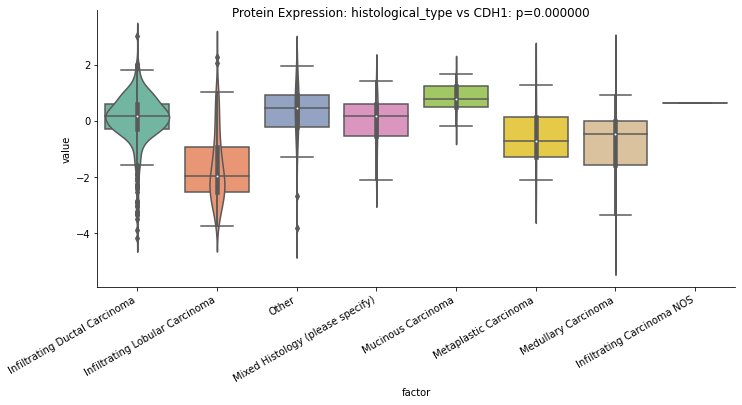

In [10]:
g = "CDH1" ## protein name 
c = "histological_type" # clinical feature

sql = '''
SELECT c.feature.value factor,protein_expression value
FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` p
JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
ON c.case_barcode = substr(p.sample_barcode,0,12) 
where c.feature.value != "null" AND p.project_short_name = "{0}"
and c.feature.key = "%s"
and gene_name = "%s"
'''.format(cancer_type)

p = 0.0000
kw =  pandas_gbq.read_gbq(sql%(c,g), project_id=project_id)
order = kw.groupby(['factor']).count().sort_values('value',ascending=False).index


axes = sns.catplot(x="factor", y="value", order=order,
        data=kw, kind="box", palette="Set2", aspect=2);
axes.fig.suptitle("Protein Expression: %s vs %s: p=%f"%(c,g,p))
sns.violinplot(x="factor", y="value",data=kw, order=order,
                scale="count", palette="Set2", aspect=2)

axes.fig.autofmt_xdate() # rotate values in x axis

plt.show()
plt.close()


# Plot Gene Expression vs Clinical feature
The code below generateS a violin plot using a user defined gene (g) expression and a user defined clinical feature (c).

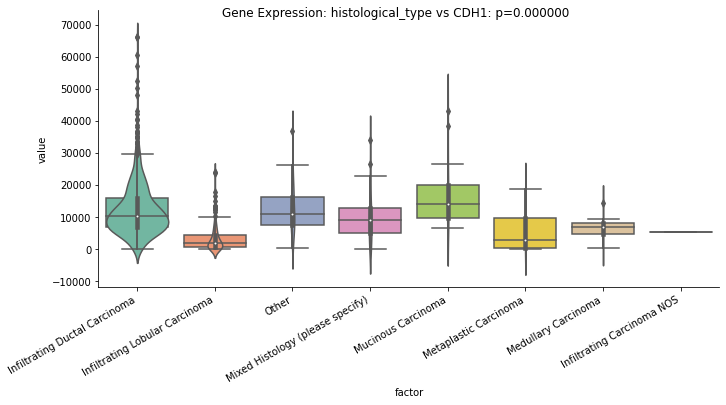

In [11]:
g = "CDH1" # Gene name
c = "histological_type"

sql = '''
SELECT c.feature.value factor,normalized_count value
FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM` p
JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
ON c.case_barcode = substr(p.sample_barcode,0,12) 
where c.feature.value != "null" AND p.project_short_name = "{0}"
and c.feature.key = "%s"
and HGNC_gene_symbol in ( SELECT gene_name FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` where gene_name = "%s" GROUP BY 1 )
'''.format(cancer_type)

p = 0.0
kw =  pandas_gbq.read_gbq(sql%(c,g), project_id=project_id)
order = kw.groupby(['factor']).count().sort_values('value',ascending=False).index

axes = sns.catplot(x="factor", y="value", order=order,
        data=kw, kind="box", palette="Set2", aspect=2);
axes.fig.suptitle("Gene Expression: %s vs %s: p=%f"%(c,g,p))
sns.violinplot(x="factor", y="value",data=kw, order=order,
                scale="count", palette="Set2", aspect=2)
axes.fig.autofmt_xdate() # rotate values in x axis

plt.show()
plt.close()
